# Training GPT-2 model on Bangla books

Necessary imports for the project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from transformers import AutoConfig, AutoTokenizer
from transformers import TFGPT2LMHeadModel

Set seaborn for better data visualization

In [2]:
sns.set()

## Preparing dataset
Initialize the project root, data, and model directories. `processed_data` directory contains selected books from renowned authors only.

In [3]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]
data_dir = project_root / 'processed_data/'
model_home = project_root / 'models/bn_gpt2'

plot_dir = model_home / 'plots'
model_saved_dir = model_home / 'model'
tokenizer_dir = model_home / 'tokenizer'
model_weights_path = model_home / 'gpt2_model_weights.h5'

os.makedirs(model_home, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(model_saved_dir, exist_ok=True)
os.makedirs(tokenizer_dir, exist_ok=True)

Get list of files in the data directory

In [4]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Then we randomly shuffle the filenames list and select 100 files.

In [5]:
random.shuffle(filenames)
filenames = filenames[:100]

Save filenames to resume training on these later

In [6]:
with open(model_home / 'filenames.pickle', 'wb') as file:
    pickle.dump(filenames, file=file)

Load filenames from pickle file

In [7]:
with open(model_home / 'filenames.pickle', 'rb') as file:
    filenames = pickle.load(file)

Split the files for training, validation, and testing. We are using 70% for training, 15% for validation and 15% for testing.

In [8]:
train_size = int(len(filenames) * 0.70)
train_filenames = filenames[:train_size]

validation_size = train_size + int(len(filenames) * 0.15)
validation_filenames = filenames[train_size:validation_size]

test_filenames = filenames[validation_size:]

`create_dataset` creates a Tensorflow Dataset from a list of filenames with a length of `max_sequence_length - 1`. `inputs` list contains first `max_sequence_length - 1` number of words except the last word, and `labels` list contains last `max_sequence_length - 1` words except the first word. `skip_size` defines how many words to skip from a tokenized string when creating `inputs` and `labels` list.

In [9]:
def create_dataset(tokenizer, filenames, max_sequence_length, skip_size):
    BATCH_SIZE = 12     # batch size 12 is needed for transformer
    BUFFER_SIZE = 1000  # for random shuffling
    inputs = []
    labels = []

    for file in tqdm(filenames):
        with open(file, 'r') as f:
            for line in f:
                string_tokenized = tokenizer.encode(line)
                for i in range(0, len(string_tokenized) - max_sequence_length + 1, skip_size):
                    ex = string_tokenized[i:i + max_sequence_length]
                    inputs.append(ex[:-1])
                    labels.append(ex[1:])
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
    return dataset

Create a tokenizer from pretrained model and add special tokens for padding, beginning, and end of sentence. And save the tokenizer.

In [10]:
tokenizer = AutoTokenizer.from_pretrained("flax-community/gpt2-bengali")
tokenizer.add_special_tokens(
    {'pad_token': '<pad>', 'bos_token': '<s>', 'eos_token': '</s>'})
tokenizer.save_pretrained(tokenizer_dir)

('/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer/tokenizer_config.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer/special_tokens_map.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer/vocab.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer/merges.txt',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer/added_tokens.json',
 '/home/shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer/tokenizer.json')

Define max sequence length for `create_dataset`.

In [11]:
max_seq_len = 200
skip_size = 50

Now we create train, validation and test dataset from the files.

In [12]:
train_dataset = create_dataset(tokenizer, train_filenames, max_seq_len, skip_size)
validation_dataset = create_dataset(tokenizer, validation_filenames, max_seq_len, skip_size)
test_dataset = create_dataset(tokenizer, test_filenames, max_seq_len, skip_size)

100%|████████████████████████████████████████| 70/70 [00:19<00:00,  3.60it/s]
2022-04-16 14:07:34.686519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 14:07:34.827589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 14:07:34.828037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 14:07:34.830891: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable th

## Creating Model

Load pretrained Bangla GPT2 model from [flax-community/gpt2-bengali](https://huggingface.co/flax-community/gpt2-bengali). Compile the pretrained model with optimizer `adam` with a learning_rate of 0.001, loss `sparse categorical crossentropy` and accuracy metric `sparse categorical accuracy`.

In [13]:
model = TFGPT2LMHeadModel.from_pretrained('flax-community/gpt2-bengali', from_pt=True)
# create model parameters
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# definining our loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(loss=[loss, *[None] * model.config.n_layer], optimizer=adam, metrics=[metric])

2022-04-16 14:08:51.407603: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['lm_head.weight', 'transformer.h.7.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.9.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are init

Create a checkpoint to save the model after each epoch.

In [14]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(str(model_home),
                                                save_weights_only=True,
                                                save_freq='epoch')

Train on `train_dataset` and use `validation_dataset` for validation.

In [16]:
history = model.fit(train_dataset, validation_data=validation_dataset,
                    epochs=3, callbacks=[checkpoint])

8890/8890 [==============================] - ETA: 0s - loss: 1.1665 - logits_loss: 1.1665 - logits_accuracy: 0.7264 - past_key_values_1_accuracy: 1.4177e-04 - past_key_values_2_accuracy: 1.4366e-04 - past_key_values_3_accuracy: 2.3843e-05 - past_key_values_4_accuracy: 2.3247e-04 - past_key_values_5_accuracy: 1.7094e-04 - past_key_values_6_accuracy: 2.5261e-04 - past_key_values_7_accuracy: 1.3917e-04 - past_key_values_8_accuracy: 1.4072e-04 - past_key_values_9_accuracy: 1.0628e-04 - past_key_values_10_accuracy: 3.1082e-04 - past_key_values_11_accuracy: 1.1015e-04 - past_key_values_12_accuracy: 1.5902e-04

2022-04-16 15:55:02.964812: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154389504 exceeds 10% of free system memory.
2022-04-16 15:55:03.125706: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154389504 exceeds 10% of free system memory.
2022-04-16 15:55:03.358984: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154389504 exceeds 10% of free system memory.


8890/8890 [==============================] - 6261s 704ms/step - loss: 1.1665 - logits_loss: 1.1665 - logits_accuracy: 0.7264 - past_key_values_1_accuracy: 1.4177e-04 - past_key_values_2_accuracy: 1.4366e-04 - past_key_values_3_accuracy: 2.3843e-05 - past_key_values_4_accuracy: 2.3247e-04 - past_key_values_5_accuracy: 1.7094e-04 - past_key_values_6_accuracy: 2.5261e-04 - past_key_values_7_accuracy: 1.3917e-04 - past_key_values_8_accuracy: 1.4072e-04 - past_key_values_9_accuracy: 1.0628e-04 - past_key_values_10_accuracy: 3.1082e-04 - past_key_values_11_accuracy: 1.1015e-04 - past_key_values_12_accuracy: 1.5902e-04 - val_loss: 3.1691 - val_logits_loss: 3.1691 - val_logits_accuracy: 0.4850 - val_past_key_values_1_accuracy: 1.2017e-04 - val_past_key_values_2_accuracy: 1.7283e-04 - val_past_key_values_3_accuracy: 1.5817e-05 - val_past_key_values_4_accuracy: 2.1611e-04 - val_past_key_values_5_accuracy: 1.5457e-04 - val_past_key_values_6_accuracy: 2.7586e-04 - val_past_key_values_7_accuracy: 1

Save the model in SavedModel format and save model weights in h5 format that huggingface can use.

In [17]:
model.save(model_saved_dir)
model.save_weights(model_weights_path, save_format='h5')

2022-04-16 16:05:33.517398: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154389504 exceeds 10% of free system memory.
2022-04-16 16:05:33.609262: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154389504 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_gpt2/model/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_gpt2/model/assets


Save model config

In [18]:
config = AutoConfig.from_pretrained("flax-community/gpt2-bengali")
config.save_pretrained(model_home / 'config.json')

Finally we evaluate the model on `test_dataset`

In [16]:
model.evaluate(test_dataset, batch_size=1024)

1696/1696 [==============================] - 437s 257ms/step - loss: 3.7646 - logits_loss: 3.7646 - logits_accuracy: 0.4520 - past_key_values_1_accuracy: 1.2283e-04 - past_key_values_2_accuracy: 2.0543e-04 - past_key_values_3_accuracy: 1.7839e-05 - past_key_values_4_accuracy: 2.1282e-04 - past_key_values_5_accuracy: 1.5734e-04 - past_key_values_6_accuracy: 2.3545e-04 - past_key_values_7_accuracy: 1.2697e-04 - past_key_values_8_accuracy: 1.2048e-04 - past_key_values_9_accuracy: 1.1631e-04 - past_key_values_10_accuracy: 2.7491e-04 - past_key_values_11_accuracy: 1.0213e-04 - past_key_values_12_accuracy: 1.3685e-04


[3.764646053314209,
 3.764646053314209,
 0.451997846364975,
 0.00012282776879146695,
 0.00020542966376524419,
 1.7839294741861522e-05,
 0.00021281640511006117,
 0.000157343820319511,
 0.00023544988653156906,
 0.00012697379861492664,
 0.00012048210919601843,
 0.00011630520748440176,
 0.0002749144332483411,
 0.00010212841880274937,
 0.0001368502271361649]

The first value in the list is the loss, and the 3rd one is the accuracy.

## Plotting training vs validation accuracy and loss

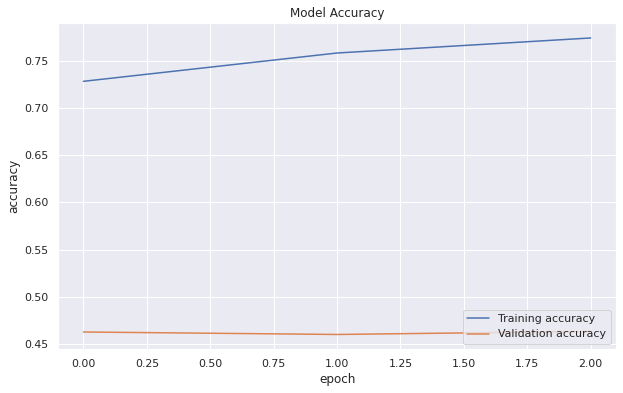

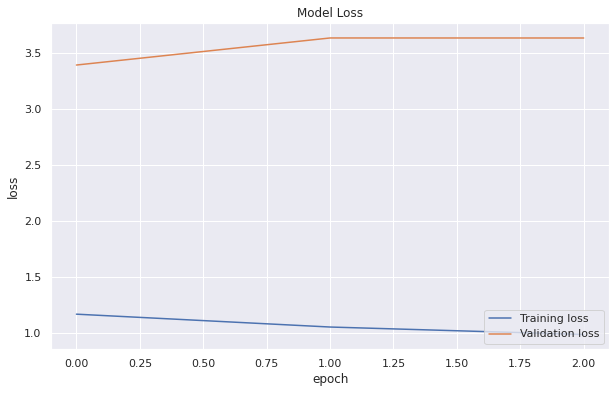

In [22]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['logits_accuracy'], label="Training accuracy")
plt.plot(history.history['val_logits_accuracy'], label="Validation accuracy")
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
fig.savefig(str(plot_dir / 'logits_accuracy.png'), dpi=fig.dpi)

fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['logits_loss'], label="Training loss")
plt.plot(history.history['val_logits_loss'], label="Validation loss")
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc="lower right")
fig.savefig(str(plot_dir / 'logits_loss.png'), dpi=fig.dpi)

## Testing the model with actual data

Load the model config from original pretrained model

In [22]:
config = AutoConfig.from_pretrained(model_home / 'config.json')

Load the tokenizer and model from local files

In [23]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)
model = TFGPT2LMHeadModel.from_pretrained(str(model_weights_path), config=config)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /home/shafquat/bangla-next-word-prediction/models/bn_gpt2/gpt2_model_weights.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


The function `generate_text` takes as input text, model, and tokenizer and generates top 5 texts with sampling `top_k` of 50 and `top_p` of 0.95. More on these sampling can be found on this [blog post](https://huggingface.co/blog/how-to-generate).

In [24]:
def generate_text(text, model, tokenizer):
    input_ids = tokenizer.encode(text, return_tensors='tf')
    outputs = model.predict(input_ids).logits

    beam_outputs = model.generate(
        input_ids,
        max_length=100,
        num_beams=5,
        no_repeat_ngram_size=2,
        num_return_sequences=5,
        early_stopping=True,
        do_sample=True,
        top_k=50,
        top_p=0.95,
    )

    print("Beam Output:\n" + 100 * '-')
    for i, beam_output in enumerate(beam_outputs):
        print("{}: {}".format(i, tokenizer.decode(
            beam_output, skip_special_tokens=True)))

Let's test our model for different texts using this function

In [28]:
text = input("Enter text: ")
generate_text(text, model, tokenizer)

Enter text: কেন


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Beam Output:
----------------------------------------------------------------------------------------------------
0: কেন, তা হলে তো আপনিও মরুন। সারাদিন এখানে ভালো লাগে না ছোটোবাবু। কোথায় কী হল, ল্যাস-সেই যে টেলিফোন বাজছে, এবং শেষ মুহূর্তের চোখে সেটা
1: কেন, আমিও তাই করেছিলাম, কিন্তু সেটাও খুব বিপজ্জনক। দীপা যেরকম ভীষণ স্বাস্থ্যবতী মেয়ে, যদিচ কুঁড়ির সঙ্গে ওর প্রেম হওয়ারই সম্ভাবনা রয়েছে, তবু বরং অনেক
2: কেন, তা হলে তো আপনিও মরুন। সারাদিন এখানে ভালো লাগে না ছোটোবাবু। কোথায় কী হল, ল্যাস-সেই যে টেলিফোন বাজছে, এবং শেষ মুহূর্তের চোখে সেটা
3: কেন, তা হলে তো আপনিও মরুন। সারাদিন এখানে ভালো লাগে না ছোটোবাবু। কোথায় কী হল, ল্যাস-সেই যে টেলিফোন বাজছে, এবং শেষ মুহূর্তের চোখে সেটা
4: কেনি, কিন্তু আমার তো বিশ্বাস, নিজের কথা ভাবতে ইচ্ছে নেই। দীপা যেমন ভীষণ সুখী, সেনদিদিও খানিকক্ষণ অবাক হয়ে গেল। তবে এটা কী হল, শশী মা লক্ষ করে দেখল ন
